# A tibble: 5 × 13
  Group      n   min   q25 median   q75   max range    sd   iqr gap_min
  <chr>  <int> <dbl> <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>
1 Top20     20 0.475 0.510  0.559 0.715     1 0.525 0.164 0.205 -0.0903
2 Top40     40 0.391 0.427  0.473 0.555     1 0.609 0.155 0.128 -0.0903
3 Top60     60 0.328 0.382  0.426 0.507     1 0.672 0.151 0.125 -0.0903
4 Top80     80 0.281 0.327  0.391 0.472     1 0.719 0.151 0.145 -0.0903
5 Top100   100 0.251 0.288  0.358 0.459     1 0.749 0.150 0.171 -0.0903
# ℹ 2 more variables: gap_median <dbl>, gap_max <dbl>
# A tibble: 5 × 13
  Segment      n   min   q25 median   q75   max  range      sd    iqr  gap_min
  <chr>    <int> <dbl> <dbl>  <dbl> <dbl> <dbl>  <dbl>   <dbl>  <dbl>    <dbl>
1 R001-020    20 0.475 0.510  0.559 0.715 1     0.525  0.164   0.205  -0.0903 
2 R021-040    20 0.391 0.408  0.426 0.459 0.472 0.0803 0.0282  0.0510 -0.0134 
3 R041-060    20 0.328 0.337  0.358 0.377 0.391 0.0635 0.0226  0.0401 -0.0100 
4 R061-08

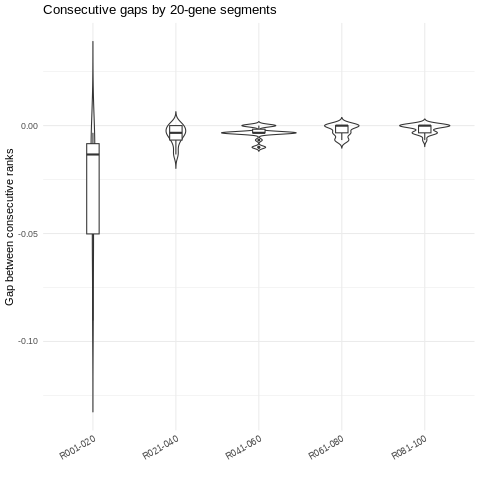

In [ ]:
%%R

## =========================
## CT Top-K Distribution Kit
## =========================
req <- c("data.table","dplyr","ggplot2","tidyr","readr","moments")
to_install <- setdiff(req, rownames(installed.packages()))
if (length(to_install)) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

# ---- settings ----
file <- "pathway/to/mt_robin_CT.csv"
topks <- c(20, 40, 60, 80, 100)
out_prefix <- "ct_topk"

# ---- helpers ----
minmax <- function(x) (x - min(x, na.rm=TRUE)) / (max(x, na.rm=TRUE) - min(x, na.rm=TRUE) + 1e-12)

consec_stats <- function(vals) {
  vals <- sort(vals, decreasing = TRUE)
  diffs <- diff(vals)
  tibble(
    n = length(vals),
    min = min(vals, na.rm=TRUE),
    q25 = quantile(vals, 0.25, na.rm=TRUE),
    median = median(vals, na.rm=TRUE),
    q75 = quantile(vals, 0.75, na.rm=TRUE),
    max = max(vals, na.rm=TRUE),
    range = max - min,
    sd = sd(vals, na.rm=TRUE),
    iqr = q75 - q25,
    gap_min = ifelse(length(diffs), min(diffs, na.rm=TRUE), NA_real_),
    gap_median = ifelse(length(diffs), median(diffs, na.rm=TRUE), NA_real_),
    gap_max = ifelse(length(diffs), max(diffs, na.rm=TRUE), NA_real_)
  )
}

# ---- load & prepare CT ----
df <- data.table::fread(file)

if (!("CT_Score_norm" %in% names(df))) {
  if (!all(c("K","TypeI","TypeII") %in% names(df))) {
    stop("Provide CT_Score_norm, or raw columns K, TypeI, TypeII to compute it.")
  }
  W <- ifelse(df$TypeII == 0, 2L, ifelse(df$TypeI == 0, 1L, 0L))
  df$CT_Score_norm <- minmax(df$K * W)
}
df$CT_Score_norm[is.na(df$CT_Score_norm)] <- 0
df <- df %>% mutate(CT_rank = rank(-CT_Score_norm, ties.method = "first")) %>%
  arrange(desc(CT_Score_norm))

# adjust topks if fewer genes
topks <- topks[topks <= nrow(df)]
if (length(topks) == 0) stop("Not enough genes to compute requested top-K cutoffs.")

# ---- (A) Overlapping cumulative Top-K sets ----
olap <- lapply(topks, function(k) {
  df %>% slice(1:k) %>% mutate(Group = paste0("Top", k))
}) %>% bind_rows()

# Density overlay
p_den_olap <- ggplot(olap, aes(x = CT_Score_norm, color = Group)) +
  geom_density(linewidth = 1) +
  labs(title = "CT score density (overlapping Top-K)", x = "CT_Score_norm", y = "Density") +
  theme_minimal()

# ECDF overlay
p_ecdf_olap <- ggplot(olap, aes(x = CT_Score_norm, color = Group)) +
  stat_ecdf(geom = "step", linewidth = 1) +
  labs(title = "CT score ECDF (overlapping Top-K)", x = "CT_Score_norm", y = "ECDF") +
  theme_minimal()

# Consecutive gaps per Top-K (overlapping)
gap_olap <- lapply(topks, function(k) {
  v <- sort(df$CT_Score_norm[1:k], decreasing = TRUE)
  if (length(v) >= 2) tibble(Gap = diff(v), Group = paste0("Top", k)) else tibble(Gap = numeric(0), Group = paste0("Top", k))
}) %>% bind_rows()

p_gap_olap <- ggplot(gap_olap, aes(x = Group, y = Gap)) +
  geom_violin(trim = FALSE, alpha = 0.2) +
  geom_boxplot(width = 0.15, outlier.size = 0.7) +
  labs(title = "Consecutive gaps in CT scores (overlapping Top-K)", x = "", y = "Gap between consecutive ranks") +
  theme_minimal()

# ---- (B) Non-overlapping 20-gene segments (1–20, 21–40, …) ----
make_seg <- function(start, end) {
  seg <- df %>% slice(start:end)
  seg %>% mutate(Segment = sprintf("R%03d-%03d", start, end))
}
segments <- list()
starts <- seq(1, min(100, nrow(df)), by = 20)
for (s in starts) {
  e <- min(s + 19, nrow(df))
  segments[[length(segments) + 1]] <- make_seg(s, e)
}
seg_df <- bind_rows(segments)

# segment density (facets)
p_den_seg <- ggplot(seg_df, aes(x = CT_Score_norm)) +
  geom_density(linewidth = 0.9) +
  facet_wrap(~ Segment, ncol = 2, scales = "free_y") +
  labs(title = "CT score density by non-overlapping 20-gene rank segments", x = "CT_Score_norm", y = "Density") +
  theme_minimal()

# segment consecutive gaps (box/violin)
gap_seg <- seg_df %>%
  group_by(Segment) %>%
  summarize(Gap = {
    v <- sort(CT_Score_norm, decreasing = TRUE)
    if (length(v) >= 2) diff(v) else numeric(0)
  }, .groups = "drop")

p_gap_seg <- ggplot(gap_seg, aes(x = Segment, y = Gap)) +
  geom_violin(trim = FALSE, alpha = 0.2) +
  geom_boxplot(width = 0.15, outlier.size = 0.7) +
  labs(title = "Consecutive gaps by 20-gene segments", x = "", y = "Gap between consecutive ranks") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

# ---- Summary table of spread and gaps ----
sum_olap <- lapply(topks, function(k) {
  tibble(Group = paste0("Top", k)) %>%
    bind_cols(consec_stats(df$CT_Score_norm[1:k]))
}) %>% bind_rows()

sum_seg <- seg_df %>%
  group_by(Segment) %>%
  reframe(consec_stats(CT_Score_norm))

summary_out <- list(
  overlapping_topk = sum_olap,
  segments_20wide  = sum_seg
)

# ---- save outputs ----
out_dir <- "pathway/to/folder"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

readr::write_csv(sum_olap, file.path(out_dir, paste0(out_prefix, "_summary_overlapping.csv")))
readr::write_csv(sum_seg,  file.path(out_dir, paste0(out_prefix, "_summary_segments.csv")))

ggsave(file.path(out_dir, paste0(out_prefix, "_density_overlapping.png")), p_den_olap, width = 7, height = 5, dpi = 300)
ggsave(file.path(out_dir, paste0(out_prefix, "_ecdf_overlapping.png")),    p_ecdf_olap, width = 7, height = 5, dpi = 300)
ggsave(file.path(out_dir, paste0(out_prefix, "_gaps_overlapping.png")),    p_gap_olap, width = 7, height = 5, dpi = 300)
ggsave(file.path(out_dir, paste0(out_prefix, "_density_segments.png")),    p_den_seg,  width = 8, height = 7, dpi = 300)
ggsave(file.path(out_dir, paste0(out_prefix, "_gaps_segments.png")),       p_gap_seg,  width = 8, height = 6, dpi = 300)

# ---- what to look at quickly in the console ----
print(sum_olap)
print(sum_seg)
p_den_olap; p_ecdf_olap; p_gap_olap
p_den_seg;  p_gap_seg

In [ ]:
%%R

## -------- Packages --------
req <- c("data.table", "dplyr", "ggplot2", "bestNormalize", "moments", "readr")
to_install <- setdiff(req, rownames(installed.packages()))
if (length(to_install)) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## -------- Helpers --------
minmax <- function(x) if (all(!is.finite(x))) x else (x - min(x, na.rm=TRUE)) / (max(x, na.rm=TRUE) - min(x, na.rm=TRUE) + 1e-12)
rin <- function(x) { r <- rank(x, ties.method = "average", na.last = "keep"); qnorm((r - 0.5) / sum(!is.na(r))) }

transform_pair <- function(mr, ct, method = c("none","yeo-johnson","box-cox","rin","quantile-match"),
                           use_minmax_after = TRUE) {
  method <- match.arg(method); eps <- 1e-9
  # Handle NAs before transformation
  mr_finite <- mr[is.finite(mr)]
  ct_finite <- ct[is.finite(ct)]

  if (method == "none") { mr_t <- mr; ct_t <- ct
  } else if (method == "yeo-johnson") {
    mr_t <- rep(NA_real_, length(mr)); mr_t[is.finite(mr)] <- predict(bestNormalize::yeojohnson(mr_finite))
    ct_t <- rep(NA_real_, length(ct)); ct_t[is.finite(ct)] <- predict(bestNormalize::yeojohnson(ct_finite))
  } else if (method == "box-cox") {
    # Box-Cox requires positive values; add minimum + epsilon
    mr_t <- rep(NA_real_, length(mr)); mr_t[is.finite(mr)] <- predict(bestNormalize::boxcox(mr_finite + abs(min(mr_finite, na.rm=TRUE)) + eps))
    ct_t <- rep(NA_real_, length(ct)); ct_t[is.finite(ct)] <- predict(bestNormalize::boxcox(ct_finite + abs(min(ct_finite, na.rm=TRUE)) + eps))
  } else if (method == "rin") {
    mr_t <- rin(mr); ct_t <- rin(ct)
  } else if (method == "quantile-match") {
    ct_sorted <- sort(ct, na.last = NA); mr_rank <- rank(mr, ties.method="average", na.last = "keep") / (sum(!is.na(mr)) + 1)
    mr_t <- rep(NA_real_, length(mr)); mr_t[is.finite(mr)] <- stats::quantile(ct_sorted, probs = mr_rank[is.finite(mr)], na.rm = TRUE, type = 7)
    mr_sorted <- sort(mr, na.last = NA); ct_rank <- rank(ct, ties.method="average", na.last = "keep") / (sum(!is.na(ct)) + 1)
    ct_t_alt <- rep(NA_real_, length(ct)); ct_t_alt[is.finite(ct)] <- stats::quantile(mr_sorted, probs = ct_rank[is.finite(ct)], na.rm = TRUE, type = 7)
    ct_t <- (ct + ct_t_alt)/2 # Simple average for combined quantile matching
  }
  if (use_minmax_after) { mr_t <- minmax(mr_t); ct_t <- minmax(ct_t) }

  # Ensure lengths match original input
  if (length(mr_t) != length(mr) || length(ct_t) != length(ct)) {
      warning("Transformation changed vector length. Check implementation.")
  }
  list(mr = mr_t, ct = ct_t)
}

consec_gap_metrics <- function(x, top_k = NULL) {
  # Remove NAs before sorting and calculating differences
  x_finite <- x[is.finite(x)]
  x_sorted <- sort(x_finite, decreasing = TRUE); if (!is.null(top_k)) x_sorted <- head(x_sorted, min(top_k, length(x_sorted)))
  diffs <- diff(x_sorted)
  c(n = length(x_sorted),
    range = if(length(x_sorted)>0) max(x_sorted) - min(x_sorted) else NA_real_,
    sd = if(length(x_sorted)>1) stats::sd(x_sorted) else NA_real_,
    skew = if(length(x_sorted)>2) moments::skewness(x_sorted) else NA_real_,
    kurt = if(length(x_sorted)>3) moments::kurtosis(x_sorted) else NA_real_,
    median_gap = if(length(diffs)>0) stats::median(diffs) else NA_real_,
    max_gap = if(length(diffs)>0) max(diffs) else NA_real_,
    min_gap = if(length(diffs)>0) min(diffs) else NA_real_)
}

mixing_summary_fast <- function(MR_t, CT_t, K, alpha_vec) {
  # Ensure MR_t and CT_t have the same length and handle potential NAs
  if (length(MR_t) != length(CT_t)) {
      stop("MR_t and CT_t have different lengths before mixing.")
  }

  # Find indices where both MR_t and CT_t are finite
  valid_indices <- which(is.finite(MR_t) & is.finite(CT_t))
  n_valid <- length(valid_indices)

  if (n_valid == 0) {
      warning("No valid scores found after transformation.")
      return(data.frame(alpha = numeric(0), K = numeric(0), overlap_with_MR = numeric(0),
                        overlap_with_CT = numeric(0), jaccard_MR = numeric(0), jaccard_CT = numeric(0)))
  }

  K_actual <- min(K, n_valid)
  if (n_valid < K) {
      warning(sprintf("Number of valid scores (%d) is less than K (%d). Adjusting K to %d.", n_valid, K, K_actual))
  }


  mr_idx_valid <- valid_indices[order(MR_t[valid_indices], decreasing = TRUE)][1:K_actual]
  ct_idx_valid <- valid_indices[order(CT_t[valid_indices], decreasing = TRUE)][1:K_actual]

  res <- lapply(alpha_vec, function(a) {
    final_a <- a * MR_t[valid_indices] + (1 - a) * CT_t[valid_indices]

    if (length(final_a) < K_actual) {
        warning(sprintf("Final score vector length (%d) less than K_actual (%d) for alpha=%f. Skipping this alpha.", length(final_a), K_actual, a))
        return(NULL) # Skip this alpha if not enough data points
    }

    # Use partial sorting only up to K_actual valid indices
    f_idx_valid <- valid_indices[order(final_a, decreasing = TRUE, partial = 1:K_actual)][1:K_actual]

    data.frame(alpha = a, K = K_actual,
               overlap_with_MR = sum(f_idx_valid %in% mr_idx_valid),
               overlap_with_CT = sum(f_idx_valid %in% ct_idx_valid),
               jaccard_MR = length(intersect(f_idx_valid, mr_idx_valid)) / length(union(f_idx_valid, mr_idx_valid)),
               jaccard_CT = length(intersect(f_idx_valid, ct_idx_valid)) / length(union(f_idx_valid, ct_idx_valid)))
  })
  # Filter out NULL results from lapply before binding rows
  dplyr::bind_rows(res[!sapply(res, is.null)])
}


assess_scores <- function(file,
                          alpha_grid = seq(0, 1, by = 0.1),
                          transform = c("none","yeo-johnson","box-cox","rin","quantile-match"),
                          K = 20, top_check_k = 16,
                          out_dir = NULL, out_prefix = "assess_scores",
                          save_plots = TRUE) {

  transform <- match.arg(transform)

  # ---- Read fully (robust) ----
  df <- data.table::fread(file)

  # ---- Sanity: show names once (optional) ----
  message("Columns: ", paste(names(df), collapse = ", "))

  # ---- Ensure we have MR & CT normalized, or compute CT from raw ----
  has_norm <- all(c("MR_Score_norm","CT_Score_norm") %in% names(df))
  if (!has_norm) {
    if (!all(c("MR_Score","K","TypeI","TypeII") %in% names(df)))
      stop("Need either MR_Score_norm & CT_Score_norm, OR raw MR_Score plus K, TypeI, TypeII.")
    W <- ifelse(df$TypeII == 0, 2L, ifelse(df$TypeI == 0, 1L, 0L))
    df$CT_Score_norm <- minmax(df$K * W)
    if (!("MR_Score_norm" %in% names(df))) df$MR_Score_norm <- minmax(df$MR_Score)
  }

  # ---- Transform (sensitivity) ----
  tr <- transform_pair(df$MR_Score_norm, df$CT_Score_norm, method = transform)
  df$MR_t <- tr$mr; df$CT_t <- tr$ct

  # ---- Distributions & gaps ----
  mr_stats_all   <- consec_gap_metrics(df$MR_t)
  ct_stats_all   <- consec_gap_metrics(df$CT_t)
  mr_stats_top16 <- consec_gap_metrics(df$MR_t, top_k = top_check_k)
  ct_stats_top16 <- consec_gap_metrics(df$CT_t, top_k = top_check_k)

  # Ensure there are enough valid data points before calculating differences for claim
  if (sum(is.finite(df$MR_t)) >= 2 && sum(is.finite(df$CT_t)) >= top_check_k) {
      mr_all_diffs <- diff(sort(df$MR_t[is.finite(df$MR_t)], decreasing = TRUE))
      ct_top_diffs <- diff(sort(df$CT_t[is.finite(df$CT_t)], decreasing = TRUE)[1:min(top_check_k, sum(is.finite(df$CT_t)))])
      claim_holds  <- (length(ct_top_diffs) > 0 && length(mr_all_diffs) > 0 &&
                       max(ct_top_diffs) < min(mr_all_diffs))
  } else {
      claim_holds <- FALSE # Not enough data to evaluate the claim
  }


  # ---- Alpha sweep (fast) ----
  alpha_results <- mixing_summary_fast(df$MR_t, df$CT_t, K = K, alpha_vec = alpha_grid)

  # ---- Plots ----
  p1 <- ggplot(df, aes(x = MR_t)) + geom_density(na.rm = TRUE) + ggtitle("MR (transformed) density")
  p2 <- ggplot(df, aes(x = CT_t)) + geom_density(na.rm = TRUE) + ggtitle("CT (transformed) density")
  p3 <- ggplot(df, aes(x = rank(-MR_t, na.last = "keep"), y = MR_t)) + geom_point(na.rm = TRUE) + ggtitle("MR rank–score")
  p4 <- ggplot(df, aes(x = rank(-CT_t, na.last = "keep"), y = CT_t)) + geom_point(na.rm = TRUE) + ggtitle("CT rank–score")

  stats_mat <- rbind(
    MR_all   = mr_stats_all,
    CT_all   = ct_stats_all,
    MR_top16 = mr_stats_top16,
    CT_top16 = ct_stats_top16
  )
  stats_df <- data.frame(Component = rownames(stats_mat), as.data.frame(stats_mat), row.names = NULL)

  # ---- Save outputs ----
  if (!is.null(out_dir)) {
    if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
    readr::write_csv(stats_df,     file.path(out_dir, paste0(out_prefix, "_stats.csv")))
    readr::write_csv(alpha_results,file.path(out_dir, paste0(out_prefix, "_alpha_mix.csv")))
    writeLines(paste0("claim_holds=", claim_holds),
               con = file.path(out_dir, paste0(out_prefix, "_claim.txt")))
    if (save_plots) {
      ggsave(file.path(out_dir, paste0(out_prefix, "_mr_density.png")),  p1, width = 7, height = 5, dpi = 300)
      ggsave(file.path(out_dir, paste0(out_prefix, "_ct_density.png")),  p2, width = 7, height = 5, dpi = 300)
      ggsave(file.path(out_dir, paste0(out_prefix, "_mr_rankscore.png")),p3, width = 7, height = 5, dpi = 300)
      ggsave(file.path(out_dir, paste0(out_prefix, "_ct_rankscore.png")),p4, width = 7, height = 5, dpi = 300)
    }
    saveRDS(list(df=df, stats=stats_df, alpha_mix=alpha_results, claim_holds=claim_holds),
            file = file.path(out_dir, paste0(out_prefix, "_res.rds")))
  }

  list(transform = transform,
       stats = stats_mat,
       claim_holds = claim_holds,
       alpha_mix = alpha_results,
       plots = list(p1=p1,p2=p2,p3=p3,p4=p4))
}

In [ ]:
%%R
## -------- Run with your folder --------
out_dir <- "pathway/to/folder"

res <- assess_scores(
  file = "pathway/to/mt_robin_CT.csv",
  alpha_grid = seq(0, 1, 0.1),
  transform = "none",
  K = 20, top_check_k = 16,
  out_dir = out_dir, out_prefix = "assess_none",
  save_plots = TRUE
)

print(res$stats)
res$claim_holds
head(res$alpha_mix)

            n     range         sd      skew      kurt  median_gap
MR_all     16 1.0000000 0.29057939 1.4188562  3.837069 -0.03716005
CT_all   6327 1.0000000 0.06330167 5.8514233 52.728728  0.00000000
MR_top16   16 1.0000000 0.29057939 1.4188562  3.837069 -0.03716005
CT_top16   16 0.4949833 0.16503797 0.7948575  2.180233 -0.01672241
               max_gap    min_gap
MR_all   -0.0001963958 -0.2818936
CT_all    0.0000000000 -0.0903010
MR_top16 -0.0001963958 -0.2818936
CT_top16 -0.0033444816 -0.0903010
  alpha K overlap_with_MR overlap_with_CT jaccard_MR jaccard_CT
1   0.0 4               4               4          1          1
2   0.1 4               4               4          1          1
3   0.2 4               4               4          1          1
4   0.3 4               4               4          1          1
5   0.4 4               4               4          1          1
6   0.5 4               4               4          1          1


In [ ]:
%%R
## -------- Run with your folder --------
out_dir <- "pathway/to/folder"

res <- assess_scores(
  file = "pathway/to/mt_robin_CT.csv",
  alpha_grid = seq(0, 1, 0.1),
  transform = "yeo-johnson",
  K = 20, top_check_k = 16,
  out_dir = out_dir, out_prefix = "assess_yeo-johnson",
  save_plots = TRUE
)

print(res$stats)
res$claim_holds
head(res$alpha_mix)

            n     range         sd      skew      kurt   median_gap
MR_all     16 1.0000000 0.28267869 0.2490447  2.291486 -0.064147409
CT_all   6327 1.0000000 0.16202899 2.8346865 11.227657  0.000000000
MR_top16   16 1.0000000 0.28267869 0.2490447  2.291486 -0.064147409
CT_top16   16 0.1014287 0.03569814 0.3764392  1.625925 -0.005635135
               max_gap     min_gap
MR_all   -0.0003662129 -0.25368322
CT_all    0.0000000000 -0.01500543
MR_top16 -0.0003662129 -0.25368322
CT_top16 -0.0010733336 -0.01500543
  alpha K overlap_with_MR overlap_with_CT jaccard_MR jaccard_CT
1   0.0 4               4               4          1          1
2   0.1 4               4               4          1          1
3   0.2 4               4               4          1          1
4   0.3 4               4               4          1          1
5   0.4 4               4               4          1          1
6   0.5 4               4               4          1          1


In [ ]:
%%R
## -------- Run with your folder --------
out_dir <- "pathway/to/folder"

res <- assess_scores(
  file = "pathway/to/mt_robin_CT.csv",
  alpha_grid = seq(0, 1, 0.1),
  transform = "rin",
  K = 20, top_check_k = 16,
  out_dir = out_dir, out_prefix = "assess_rin",
  save_plots = TRUE
)

print(res$stats)
res$claim_holds
head(res$alpha_mix)

            n     range         sd         skew     kurt   median_gap
MR_all     16 1.0000000 0.26643727 6.502403e-17 2.432477 -0.052957058
CT_all   6327 1.0000000 0.18059533 1.506551e+00 4.168439  0.000000000
MR_top16   16 1.0000000 0.26643727 6.502403e-17 2.432477 -0.052957058
CT_top16   16 0.2337703 0.06472789 1.179669e+00 3.715113 -0.009187016
              max_gap     min_gap
MR_all   -0.042095384 -0.14621561
CT_all    0.000000000 -0.23693706
MR_top16 -0.042095384 -0.14621561
CT_top16 -0.005180427 -0.06862022
  alpha K overlap_with_MR overlap_with_CT jaccard_MR jaccard_CT
1   0.0 4               4               4          1          1
2   0.1 4               4               4          1          1
3   0.2 4               4               4          1          1
4   0.3 4               4               4          1          1
5   0.4 4               4               4          1          1
6   0.5 4               4               4          1          1


In [ ]:
%%R
## -------- Run with your folder --------
out_dir <- "pathway/to/folder"

res <- assess_scores(
  file = "pathway/to//mt_robin_CT.csv",
  alpha_grid = seq(0, 1, 0.1),
  transform = "quantile-match",
  K = 20, top_check_k = 16,
  out_dir = out_dir, out_prefix = "assess_quantile-match",
  save_plots = TRUE
)

print(res$stats)
res$claim_holds
head(res$alpha_mix)

            n     range        sd      skew     kurt   median_gap      max_gap
MR_all     16 1.0000000 0.2739642 2.4862762 8.105166  0.000000000  0.000000000
CT_all   6327 1.0000000 0.1560855 2.0517775 6.573766  0.000000000  0.000000000
MR_top16   16 1.0000000 0.2739642 2.4862762 8.105166  0.000000000  0.000000000
CT_top16   16 0.2774662 0.0924289 0.7900033 2.175050 -0.009453193 -0.002019312
             min_gap
MR_all   -0.48387097
CT_all   -0.10664961
MR_top16 -0.48387097
CT_top16 -0.05033954
  alpha K overlap_with_MR overlap_with_CT jaccard_MR jaccard_CT
1   0.0 4               4               4          1          1
2   0.1 4               4               4          1          1
3   0.2 4               4               4          1          1
4   0.3 4               4               4          1          1
5   0.4 4               4               4          1          1
6   0.5 4               4               4          1          1
